In [180]:
import numpy as np
from skimage import io, util, measure
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import pandas as pd

from os import path
import stackview
import matplotlib.pyplot as plt

def make_image_from_heightmap(heightmap,maxZ):
    # Reconstruct flattened movie
    heightmap[heightmap >=maxZ] = maxZ-1
    YY,XX = heightmap.shape
    # Iz[Iz >= ZZ] = ZZ-1
    # NB: tried using np.take and np.choose, doesn't work bc of size limit. DO NOT use np.take
    height_image = np.zeros((maxZ,YY,XX),dtype=np.uint16)
    for x in range(XX):
        for y in range(XX):
            height_image[heightmap[y,x],y,x] = 1
    return height_image

def get_z_gradient(imblur,sign):
    _tmp = imblur.copy().astype(float)
    _tmp[np.isnan(_tmp)] = 0
    _tmp_diff = sign * np.diff(_tmp,axis=0)
    
    return _tmp_diff

def find_z_of_maximal_gradient(im_diff,z_shift,threshold=0.2,method='threshold'):
    ZZ,YY,XX = im_diff.shape

    if method == 'maximum':
        idx = np.argmax(im_diff,axis=0)

    if method == 'threshold':
        idx = np.zeros((YY,XX))
        for x in range(XX):
            for y in range(YY):
                hits = np.where(im_diff[:,y,x] > threshold)[0]
                if len(hits)>0:
                    idx[y,x] = hits[0]
    heightmap = idx
    
    Iz = np.round(heightmap + z_shift).astype(int)
    Iz[Iz >= ZZ] = ZZ-1
    return Iz
    

# 0. Load stack

In [168]:
dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R2/1. Day 11/'

dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/F1 cage 3015 MemGFP NoFUCCI/R2/1. Day 18'
imstack = io.imread(path.join(dirname,'B_reg.tif'))

stackview.slice(imstack, zoom_factor=0.5 )

# 1. Tune parameters and calculate preliminary mesh

In [169]:
ZZ,YY,XX = imstack.shape

# Pixels to blur in XY or Z
XY_sigma = 15
Z_sigma = 10

im_z_blur = gaussian_filter(imstack,sigma=[Z_sigma,XY_sigma,XY_sigma])

In [170]:
cropper = stackview.crop(im_z_blur.transpose(),zoom_factor=0.5)
cropper

_Cropper(children=(HBox(children=(VBox(children=(VBox(children=(IntRangeSlider(value=(0, 1024), description='Z…

In [171]:
# Crop along the z-axis, and save the crop range for padding later
Z_top = cropper.range[2].start
Z_bottom = cropper.range[2].stop
cropped_blur = im_z_blur[cropper.range[2],...]

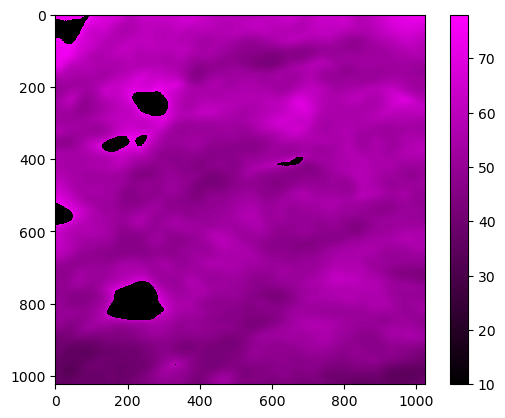

In [172]:
# Set sign to +1 if using 'collagen only' and -1 if keratinocytes only
sign = +1

# How much to 'shift up or down' (NB: +z is down)
z_shift = +10

im_diff = get_z_gradient(cropped_blur,sign)
Iz = find_z_of_maximal_gradient(im_diff/im_diff.max(),z_shift,method='threshold',threshold=0.2)
Iz += Z_top

stackview.imshow(Iz.astype(np.int8),axes=True,colormap='pure_magenta',colorbar=True)

In [173]:
# Reconstruct the height image
height_image = make_image_from_heightmap(Iz + Z_top,ZZ)
stackview.switch(
    {'image': imstack,
     'height_image':height_image},
    colormap=["pure_magenta", "pure_green",'pure_cyan'],
    toggleable=True,
    zoom_factor=0.5,
)

In [174]:
# Orthogonal view
stackview.switch(
    {'image': imstack.transpose(),
     'height_image':height_image.transpose()},
    colormap=["pure_magenta", "pure_green",'pure_cyan'],
    toggleable=True,
    zoom_factor=1,
)

# Repair any holes

In [175]:

# Find the single connected region with the largest area, from which to 
# reconstruct the basal surface/
L = measure.label(height_image,connectivity=2)
df = pd.DataFrame(measure.regionprops_table(L,properties=['label','area'])).sort_values('area')
surf_region = df.iloc[-1]['label']


In [176]:
# interpolate the 'missing' regions
Z,Y,X = np.where(L == surf_region)
grid_y,grid_x = np.meshgrid(range(YY),range(XX))
fixed_heightmap = np.round(
    interpolate.griddata(np.array([Y,X]).T,Z,(grid_y,grid_x), method='linear')).astype(int).T

# Remake the height image
height_image = make_image_from_heightmap(fixed_heightmap,ZZ)


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_87260/3339497404.py:5: RuntimeWarning: invalid value encountered in cast
  interpolate.griddata(np.array([Y,X]).T,Z,(grid_y,grid_x), method='linear')).astype(int).T


In [177]:
stackview.switch(
    {'image': imstack,
     'height_image':height_image,},
    colormap=["pure_magenta", "pure_green"],
    toggleable=True,
    zoom_factor=0.5,
)


In [178]:
# Orthogonal
stackview.switch(
    {'image': imstack.transpose(),
     'height_image':height_image.transpose()},
    colormap=["pure_magenta", "pure_green",'pure_cyan'],
    toggleable=True,
    zoom_factor=1,
)

# Save heightmap and height images

In [179]:
io.imsave(path.join(dirname,'heightmap.tif'), fixed_heightmap.astype(np.uint16),check_contrast=False)
io.imsave(path.join(dirname,'height_image.tif'), height_image.astype(np.uint16),check_contrast=False)
